# Problem 9 — Reproducible Modeling

This notebook demonstrates a **reproducible** modeling workflow:

1. Freeze randomness (deterministic seeds)
2. Load fixed features/target (from Problem 5)
3. Deterministic train/test split with `random_state`
4. Train baseline models with fixed seeds
5. Save metrics and artifacts

_Assumes you've already run:_

```bash
python src/preprocessing.py --in data/raw/asthma_disease_data.csv --out data/processed/asthma_clean.csv
python src/build_features.py --in data/processed/asthma_clean.csv --outdir data/processed

/ or their relative notebooks : 03_preprocessing.ipynb and 05_feature_engeneering.ipynb /
```

In [45]:
# 0) Ensure required processed files exist by re-running preprocessing & feature building
!python ../src/preprocessing.py --in ../data/raw/asthma_disease_data.csv --out ../data/processed/asthma_clean.csv
!python ../src/build_features.py --in ../data/processed/asthma_clean.csv --outdir ../data/processed


Saved processed dataset: ../data/processed/asthma_clean.csv  shape=(2392, 28)
Saved features to ../data/processed/features.csv and ../data/processed/target.csv  | X:(2392, 29) y:(2392,)


In [46]:
# 1) Freeze randomness (local helper; minimal & self-contained)
import os, random, numpy as np

def set_seeds(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds(42)
print("Seeds set to 42.")

Seeds set to 42.


In [47]:
# 2) Imports
import json
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

ARTIFACTS_DIR = Path("../artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Artifacts will be written to: {ARTIFACTS_DIR.resolve()}")

Artifacts will be written to: /home/deyan/DEV/Softuni Data Science/07.Data-Science-Project-Architecture-Lab/Repo Here/data_science_course_HW/artifacts


In [48]:
# 3) Load features and target saved in Problem 5
features_path = Path("../data/processed/features.csv")
target_path   = Path("../data/processed/target.csv")

X = pd.read_csv(features_path)
y = pd.read_csv(target_path).squeeze("columns").astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class balance (y):\n", y.value_counts(normalize=True).round(3))
display(X.head())

X shape: (2392, 29)
y shape: (2392,)
Class balance (y):
 Diagnosis
0    0.948
1    0.052
Name: proportion, dtype: float64


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,...,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,FEV1_FVC_ratio,ExposureMean,SymptomCount
0,0.965740,0,1,0,-1.583956,0,-1.432857,0.160247,0.971811,0.809782,...,0.921213,0,0,1,0,0,1,-1.171599,-0.775905,2
1,-0.747054,1,2,2,-0.623674,0,0.291367,0.453343,-1.077424,-1.037492,...,-1.565249,1,0,0,1,1,1,1.154722,0.180078,4
2,0.687989,0,2,1,-1.229960,0,0.581572,1.435199,-0.102975,-1.211099,...,0.983664,1,1,1,0,1,1,-1.031621,-1.347017,5
3,-0.098970,1,2,1,1.566787,0,-1.257069,0.276422,-1.597920,-1.510653,...,-1.106339,1,0,1,1,1,0,1.217126,-0.596290,4
4,0.873156,0,0,3,-1.106468,0,-0.154204,-0.651878,1.506095,-1.374640,...,-0.516905,1,1,1,0,0,1,0.788207,-0.561946,4


In [49]:
# 4) Deterministic stratified split to preserve class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Class distribution in train:\n", y_train.value_counts(normalize=True))


Train shape: (1913, 29)  Test shape: (479, 29)
Class distribution in train:
 Diagnosis
0    0.948249
1    0.051751
Name: proportion, dtype: float64


## Baseline models (fixed seeds)

- **Logistic Regression** (good linear baseline)
- **Random Forest** (non-linear baseline)

Both use `random_state=42` for determinism. If features were already scaled in Problem 5, we can fit directly. If not, LR still typically works, but you can add a scaler pipeline if needed.

In [50]:
from sklearn.metrics import (
    precision_recall_curve, classification_report,
    f1_score, roc_auc_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

SEED = 42

def evaluate_and_report(model_name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)

    # get probabilities
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        df = model.decision_function(X_te)
        proba = (df - df.min()) / (df.max() - df.min() + 1e-9)
    else:
        # last resort: use hard preds as a pseudo-prob
        hard = model.predict(X_te)
        proba = hard.astype(float)

    # pick threshold that maximizes F1 for the positive class
    prec, rec, thr = precision_recall_curve(y_te, proba)
    f1s = 2 * prec * rec / (prec + rec + 1e-9)
    best_idx = f1s.argmax()
    best_thr = 0.5 if best_idx >= len(thr) else float(thr[best_idx])

    y_pred = (proba >= best_thr).astype(int)

    metrics = {
        "model": model_name,
        "best_threshold": best_thr,
        "accuracy": float(accuracy_score(y_te, y_pred)),
        "f1": float(f1_score(y_te, y_pred, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_te, proba)) if len(np.unique(y_te)) == 2 else None,
    }

    print(f"\n=== {model_name} (best_thr={best_thr:.3f}) ===")
    print(json.dumps(metrics, indent=2))
    print("\nClassification report:\n", classification_report(y_te, y_pred, zero_division=0))
    return metrics, y_pred

# class-balanced models
models = [
    ("LogisticRegression_bal",
     LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED)),
    ("RandomForest_bal",
     RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=SEED, n_jobs=-1)),
]

results = []
for name, mdl in models:
    m, _ = evaluate_and_report(name, mdl, X_train, y_train, X_test, y_test)
    results.append(m)

results_df = pd.DataFrame(results).sort_values(by=["roc_auc", "f1", "accuracy"], ascending=False)
display(results_df)



=== LogisticRegression_bal (best_thr=0.602) ===
{
  "model": "LogisticRegression_bal",
  "best_threshold": 0.6024409712995196,
  "accuracy": 0.8100208768267223,
  "f1": 0.16513761467889906,
  "roc_auc": 0.5579735682819383
}

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       454
           1       0.11      0.36      0.17        25

    accuracy                           0.81       479
   macro avg       0.53      0.60      0.53       479
weighted avg       0.92      0.81      0.85       479


=== RandomForest_bal (best_thr=0.100) ===
{
  "model": "RandomForest_bal",
  "best_threshold": 0.1,
  "accuracy": 0.9018789144050104,
  "f1": 0.1132075471698113,
  "roc_auc": 0.4397797356828194
}

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       454
           1       0.11      0.12      0.11        25

    accuracy                         

,model,best_threshold,accuracy,f1,roc_auc
0,LogisticRegression_bal,0.602441,0.810021,0.165138,0.557974
1,RandomForest_bal,0.100000,0.901879,0.113208,0.439780


In [51]:
# Oversample the minority class (training set only)
from imblearn.over_sampling import SMOTE

SEED = 42
smote = SMOTE(random_state=SEED, k_neighbors=5)  # k_neighbors can be tuned (3–7 often fine)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True).round(3).to_dict())
print("After  SMOTE:", y_train_res.value_counts(normalize=True).round(3).to_dict())
print("New train shape:", X_train_res.shape)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x793981bc4a60>
Traceback (most recent call last):
  File "/home/deyan/anaconda3/envs/asthma-lab/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/deyan/anaconda3/envs/asthma-lab/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/deyan/anaconda3/envs/asthma-lab/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/deyan/anaconda3/envs/asthma-lab/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Before SMOTE: {0: 0.948, 1: 0.052}
After  SMOTE: {0: 0.5, 1: 0.5}
New train shape: (3628, 29)


In [54]:
# Models without class_weight (since data is now balanced)
models_smote = [
    ("LogisticRegression_smote",
     LogisticRegression(max_iter=1000, class_weight=None, random_state=SEED)),
    ("RandomForest_smote",
     RandomForestClassifier(n_estimators=300, class_weight=None, random_state=SEED, n_jobs=-1)),
]

results_smote = []
for name, mdl in models_smote:
    m, _ = evaluate_and_report(name, mdl, X_train_res, y_train_res, X_test, y_test)
    results_smote.append(m)

results_smote_df = pd.DataFrame(results_smote).sort_values(by=["roc_auc", "f1", "accuracy"], ascending=False)
display(results_smote_df)




=== LogisticRegression_smote (best_thr=0.428) ===
{
  "model": "LogisticRegression_smote",
  "best_threshold": 0.427513206761369,
  "accuracy": 0.8768267223382046,
  "f1": 0.1917808219178082,
  "roc_auc": 0.6606167400881058
}

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       454
           1       0.15      0.28      0.19        25

    accuracy                           0.88       479
   macro avg       0.55      0.59      0.56       479
weighted avg       0.92      0.88      0.89       479


=== RandomForest_smote (best_thr=0.213) ===
{
  "model": "RandomForest_smote",
  "best_threshold": 0.21333333333333335,
  "accuracy": 0.7035490605427975,
  "f1": 0.14457831325301204,
  "roc_auc": 0.5746696035242291
}

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.72      0.82       454
           1       0.09      0.48      0.14        25

    accuracy  

,model,best_threshold,accuracy,f1,roc_auc
0,LogisticRegression_smote,0.427513,0.876827,0.191781,0.660617
1,RandomForest_smote,0.213333,0.703549,0.144578,0.574670


Best model: LogisticRegression_bal


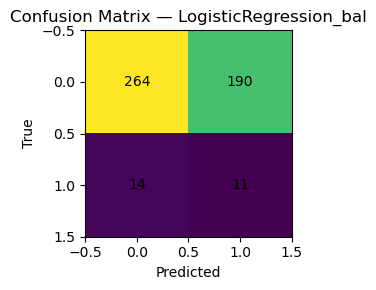

Saved:
- ../artifacts/problem9_confusion_matrix_LogisticRegression_bal.png
- ../artifacts/problem9_metrics.json


In [53]:
# 6) Save metrics + confusion matrix for the best model
best = results_df.iloc[0]
best_name = best["model"]
print("Best model:", best_name)

yhat_best = yhat_rf if best_name == "RandomForest" else yhat_lr
cm = confusion_matrix(y_test, yhat_best)

fig = plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout()
cm_path = ARTIFACTS_DIR / f"problem9_confusion_matrix_{best_name}.png"
plt.savefig(cm_path, dpi=150)
plt.show()

# Save metrics JSON
metrics_path = ARTIFACTS_DIR / "problem9_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(results, f, indent=2)

print("Saved:")
print("-", cm_path)
print("-", metrics_path)

## Reproducibility Notes

- **Seeds**: `set_seeds(42)` + `random_state=42` for splits and models.
- **Deterministic split**: `train_test_split(..., stratify=y, random_state=42)`.
- **Artifacts**: metrics (`problem9_metrics.json`) and confusion matrix image saved to `../artifacts/`.
- **Environment**: Use the repo's `environment.yml` + `pip install -e .` so imports and versions are consistent.

Optional (outside this notebook):
- Run `python scripts/capture_env.py` to generate `versions.txt` (exact package versions).
- Run `python scripts/hash_data.py` to produce `data/CHECKSUMS.txt` for data integrity tracking.